# Topic Modeling Using LDA and K-Means Clustering

## Import libraries

In [6]:
import pandas as pd
import boto3
import os
import gensim
import numpy as np
import re
import matplotlib.pyplot as plt
import spacy
import gensim
import torch
import umap.umap_ as umap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from io import BytesIO
from dotenv import load_dotenv
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import BertTokenizer, BertModel

# plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-v0_8')

In [7]:
import warnings
warnings.filterwarnings("ignore")

## Load data from S3

In [8]:
# Load the environment file with credentials
dotenv_path = os.path.join(os.path.abspath(''), 'aws-credentials.env')
load_dotenv(dotenv_path)

BUCKET_NAME = "nlp-topic-modeling-project" # S3 bucket name
KEY = 'processed_insurance_journal_articles.parquet'

session = boto3.Session(
        aws_access_key_id=os.environ['aws_access_key_id'],
        aws_secret_access_key=os.environ['aws_secret_access_key']
    )

# Creating S3 resource from Session
s3 = session.resource('s3')

# Create a buffer, which stores the data in memory
buffer = BytesIO()

# Download file from S3
s3.Object(BUCKET_NAME, KEY).download_fileobj(buffer)

# Read the buffer
df = pd.read_parquet(buffer)

## Preprocessing

In [200]:
import spacy

In [5]:
nlp = spacy.load('en_core_web_md')

In [6]:
# Function for lemmatization using spacy
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [7]:
# Removing special characters and numbers
df['clean_article'] = df['article'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)) 

# Convert to lowercase
df['clean_article'] = df['clean_article'].apply(lambda x: x.lower()) 

# Lemmatize
df['clean_article'] = df['clean_article'].apply(lemmatize) 

## Create vectorizers

**`max_df`**` : float in range [0.0, 1.0] or int, default=1.0`<br>
When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). Aka, if this word occurs in more than 95% of the articles, drop it. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**`min_df`**` : float in range [0.0, 1.0] or int, default=1`<br>
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None. We want at least two occurence of the vocabulary.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [156]:
count_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english', ngram_range=(1,2))
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english', ngram_range=(1,2))

In [11]:
# Rows (i) are documents and columns (j) are words
cv_matrix = count_vectorizer.fit_transform(df['clean_article'])
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_article'])

## Latent Dirichlet Distribution

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

In [211]:
LDA = LatentDirichletAllocation(n_components=17,random_state=42)

In [212]:
LDA.fit(cv_matrix)

LatentDirichletAllocation(n_components=17, random_state=42)

## Word-Topic Distribution

`LDA.components_` gives the **word-topic distribution (φ)**. It's a matrix where each row represents a topic, and the columns represent the words in the vocabulary. The values are the number of times each word is assigned to each topic.

* The rows (i) represent topics
* The columns (j) represent words
* The value at index (i, j) represents the **importance** or weight of word j in topic i.

In [217]:
LDA.components_.shape

(17, 38836)

In [218]:
single_topic = LDA.components_[0]

In [219]:
# Returns the indices that would sort this array.
args = single_topic.argsort()

In [220]:
# The word and the weight of word most representative of this topic. 
count_vectorizer.get_feature_names_out()[args[-1]], single_topic[args[-1]]

('vehicle', 447.99016370081154)

In [35]:
# Dispaying top words for topics 0 to 5
for index,topic in enumerate(LDA.components_[:5]):
    print(f'THE TOP WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-30:][::-1]])
    print('\n')

THE TOP WORDS FOR TOPIC #0
['vehicle', 'tesla', 'recall', 'safety', 'report', 'year', 'nhtsa', 'crash', 'driver', 'traffic', 'cost', 'increase', 'car', 'claim', 'model', 'auto', 'million', 'automaker', 'inflator', 'investigation', 'new', 'death', 'highway', 'make', 'national', 'high', 'agency', 'injury', 'issue', 'company']


THE TOP WORDS FOR TOPIC #1
['claim', 'worker', 'new', 'company', 'court', 'employee', 'risk', 'cyber', 'policy', 'year', 'insurer', 'work', 'case', 'time', 'insurance', 'business', 'include', 'make', 'exclusion', 'law', 'industry', 'coverage', 'change', 'need', 'state', 'issue', 'war', 'damage', 'use', 'injury']


THE TOP WORDS FOR TOPIC #2
['bank', 'svb', 'financial', 'deposit', 'risk', 'report', 'company', 'insurance', 'year', 'bond', 'rate', 'banking', 'regulator', 'worker', 'fed', 'policy', 'loan', 'federal', 'failure', 'firm', 'valley', 'silicon valley', 'silicon', 'asset', 'valley bank', 'crypto', 'billion', 'capital', 'investment', 'fdic']


THE TOP WORDS F

In [14]:
def word_plot(df, vectorizer, desired_label, idx, n_words=30):
    """
    Plots the top words for a specified topic or cluster.

    Parameters:
    - df: DataFrame containing articles and their associated labels.
    - vectorizer: Fitted vectorizer (like TF-IDF or CountVectorizer).
    - desired_label: The column in df that contains the labels for topics or clusters.
    - idx: Identifier for the topic or cluster you want to visualize.
    - n_words: Number of top words to plot.
    - method: Either 'lda' or 'kmeans' to specify the technique used for topic modeling or clustering.
    """
    vectorizer.fit(df['clean_article'])
    
    # Get documents that belong to the cluster or topic specified by idx
    docs_in_cluster = df[df[desired_label] == idx]['clean_article'].tolist()

    # Vectorize these documents
    cluster_vectors = vectorizer.transform(docs_in_cluster).toarray()

    # Calculate the average vector for the cluster
    word_weights = np.mean(cluster_vectors, axis=0)
    
    # Get the indices for the top words
    top_word_indices = word_weights.argsort()[-n_words:][::-1]

    # Get the words corresponding to these indices
    feature_names = vectorizer.get_feature_names_out()
    top_words = [feature_names[i] for i in top_word_indices]
    
    plt.figure(figsize=(15, 10))
    plt.barh(top_words, word_weights[top_word_indices])
    plt.xlabel('Weight')
    plt.title(f'Top {n_words} words for topic {idx}')
    plt.gca().invert_yaxis()
    plt.show()

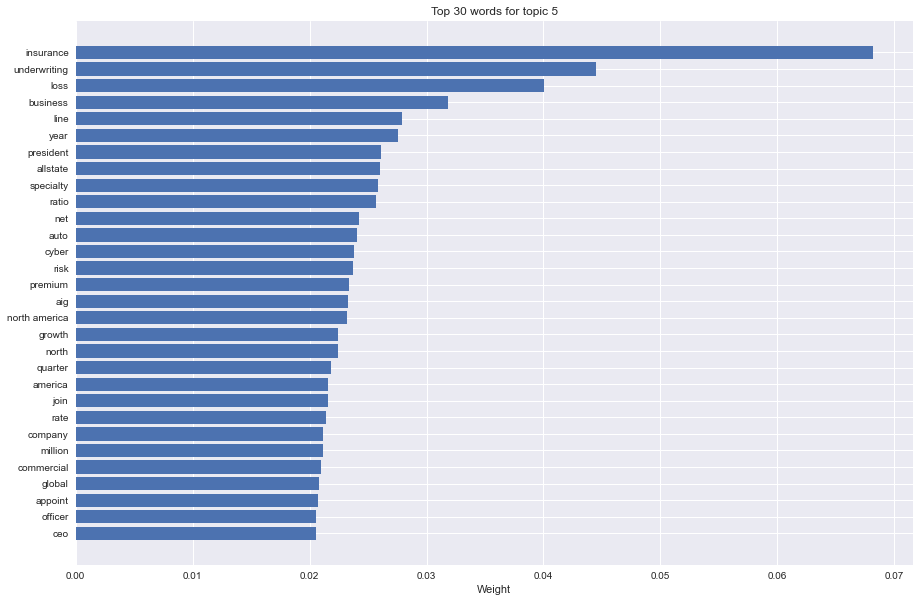

In [430]:
# Display the topic to word importance plot. Select the topic number.
word_plot(df, tfidf_vectorizer, 'lda_label', 5)

## Document-Topic Distribution

The `document-topic distribution (θ)` can be obtained by transforming your document-term matrix (cv_matrix).

* The rows represent the documents.
* The columns represent the topics.
* The value at index (i, j) represents the **probability distribution of topics** for documents.

In [223]:
topic_results = LDA.transform(cv_matrix)

In [18]:
# Hard assign topics to documents
df['lda_label'] = topic_results.argmax(axis=1)

# Evaluate Model

## Perplexity

A common metric for probabilistic models, including LDA. Lower perplexity scores are generally better, indicating that the model is more confident in its predictions. However, it's worth noting that a lower perplexity does not always imply a better interpretable model.

**Lower perplexity scores are generally better**, indicating that the model is more confident in its predictions.

In [100]:
# Calculate Perplexity.
perplexity = LDA.perplexity(cv_matrix)
print("Perplexity: ", perplexity)

Perplexity:  7641.888070022741


## Topic Coherence

Topic Coherence measures the semantic similarity between high scoring words in a topic. It's used to determine how coherent the words are within a topic.  If words from the same topic frequently appear together in the text, they are likely related and contribute to a higher coherence score. A topic is considered coherent if its top N words are frequently mentioned together in the corpus.

Topic coherence scores, particularly the cv metric, typically range between 0 and 1. High coherence is closer to 1 and low coherence is closer to 0.

**High coherence scores are better**.

In [8]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [19]:
def get_topic_words(df, vectorizer, column_label, top_n_words=30):
    
    topics = []
    
    for label in df[column_label].unique():
        
        # Get documents with this label
        docs_in_cluster = df[df[column_label] == label]['clean_article'].tolist()
        
        # Fit the Tfidf-Vectorizer to the documents in this cluster
        X = vectorizer.fit_transform(docs_in_cluster)
        
        # Sum tf-idf features for each term throughout all the documents in this cluster
        term_scores = np.sum(X.toarray(), axis=0)
        
        # Get indices sorted by top tf-idf scores
        top_indices = np.argsort(term_scores)[::-1][:top_n_words]
        
        # Get the top words
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        
        topics.append(top_words)
        
    return topics

In [20]:
def get_topic_coherence(df, vectorizer, column_label, coherence_type='c_v'):
    
    # Tokenize documents
    texts = [doc.split() for doc in df['clean_article']]
    
    # Create a Gensim dictionary
    dictionary = Dictionary(texts)
    
    # Get topics
    topics = get_topic_words(df, vectorizer, column_label)
    
    # Compute Coherence Score
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=coherence_type)
    coherence_score = coherence_model.get_coherence()
    
    return coherence_score

## Topic Diversity

Topic Diversity is a measure to evaluate the distinctness or separateness of topics in a topic model. If topics in a model are very similar to each other, the model may not be very informative. Hence, it's desirable that the topics are diverse

The topic_diversity function will return a score between 0 and 1. Higher values indicate greater diversity between the topics.

**Higher diversity scores are better.**

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
def get_topic_vectors(df, vectorizer, column_label):
    
    # Fit the TfidfVectorizer on the entire dataset
    vectorizer.fit(df['clean_article'].tolist())
    
    topic_vectors = []
    
    for label in df[column_label].unique():
        # Get documents with this label
        docs_in_cluster = df[df[column_label] == label]['clean_article'].tolist()
        
        # Transform the documents into a document-term matrix based on the fitted model
        X = vectorizer.transform(docs_in_cluster)
        
        # Compute the average tf-idf vector for this cluster
        avg_vector = np.mean(X.toarray(), axis=0)
        
        topic_vectors.append(avg_vector)
        
    return np.vstack(topic_vectors)  # Use vstack to stack arrays vertically

In [23]:
def get_topic_diversity(df, vectorizer, column_label):
    
    # Get topic vectors
    topic_vectors = get_topic_vectors(df, vectorizer, column_label)
    
    # Normalize the vectors
    topic_vectors = topic_vectors / np.linalg.norm(topic_vectors, axis=1, keepdims=True)
    
    # Calculate pairwise cosine similarity
    similarities = cosine_similarity(topic_vectors)
    
    # Set diagonal values to 0 (as they are always 1)
    np.fill_diagonal(similarities, 0)
    
    # Compute the average pairwise similarity
    avg_similarity = np.mean(similarities)
    
    # Compute topic diversity
    diversity = 1 - avg_similarity
    
    return diversity

## Collect Evaluation Metric Scores

In [32]:
n_components = np.arange(5,21)

coherence_scores = []
diversity_scores = []
perplexity_scores = []

for n_component in n_components:
    
    # Create LDA and fit document-topic matrix
    LDA = LatentDirichletAllocation(n_components=n_component,random_state=42)
    LDA.fit(cv_matrix)
    topic_results = LDA.transform(cv_matrix)
    df['lda_label'] = topic_results.argmax(axis=1)
    
    # Calculate scores for each N number of topics
    coh_score = get_topic_coherence(df, tfidf_vectorizer, 'lda_label')
    div_score = get_topic_diversity(df, tfidf_vectorizer, 'lda_label')
#     coh_score = lda_calc_topic_coherence(LDA.components_, df, count_vectorizer, top_n_words=20)
#     div_score = calc_topic_diversity(LDA.components_)
    
    # Collect scores
    coherence_scores.append(coh_score)
    diversity_scores.append(div_score)
    perplexity_scores.append(LDA.perplexity(cv_matrix))

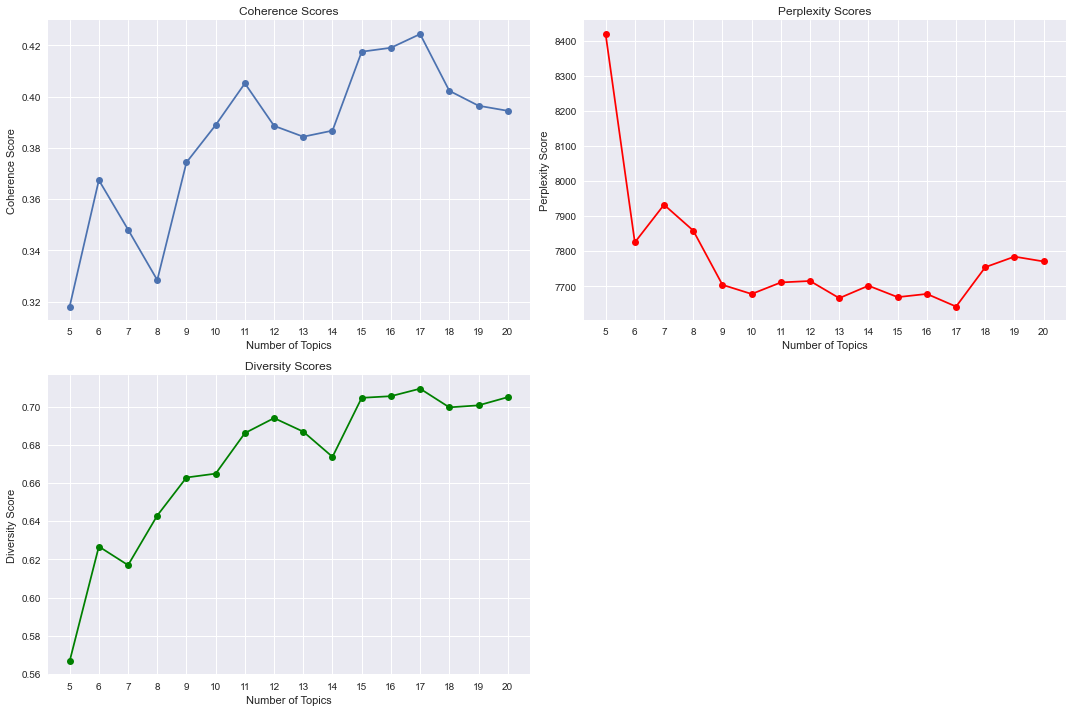

In [33]:
plt.figure(figsize=(15, 10))

start_topic = 5

# Assuming number of topics or some range
topics_range = list(range(start_topic, start_topic + len(coherence_scores)))  

# Coherence scores plot
plt.subplot(2, 2, 1)
plt.plot(topics_range, coherence_scores, marker='o')
plt.title("Coherence Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(topics_range)
plt.tight_layout()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Perplexity scores plot
plt.subplot(2, 2, 2)
plt.plot(topics_range, perplexity_scores, marker='o', color='r')
plt.title("Perplexity Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.xticks(topics_range)
plt.tight_layout()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Diversity scores plot
plt.subplot(2, 2, 3)
plt.plot(topics_range, diversity_scores, marker='o', color='g')
plt.title("Diversity Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Diversity Score")
plt.xticks(topics_range)
plt.tight_layout()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### ***From the graph, 17 numbers of topics seem reasonable.

In [14]:
LDA = LatentDirichletAllocation(n_components=17,random_state=42)
LDA.fit(cv_matrix)
topic_results = LDA.transform(cv_matrix)
df['lda_label'] = topic_results.argmax(axis=1)

# K-means Clustering on Topics

Even after assigning the dominant topic to each user using argmax, there might still be nuances in their topic distributions. k-means can help in grouping together users based on these nuances, potentially creating more cohesive and targeted segments. For LDA, I am just finding a dominant topic and assigning documents to that topic. However, clustering will use all elements in the probability distribution.

Warning: Since K-mean cluster uses distance based method for clustering, and the document-topic matrix is not a vector but a probability distribution of topics for each document, a standard K-mean clustering may not capture the signals in the document well. Rather, using a probability distribution based clustering may be better.

## Using only K-means Cluster for Classification

In [15]:
from sklearn.cluster import KMeans

## Determine the Number of Clusters

Upgrade threadpoolctl to version >3.

### Elbow Method

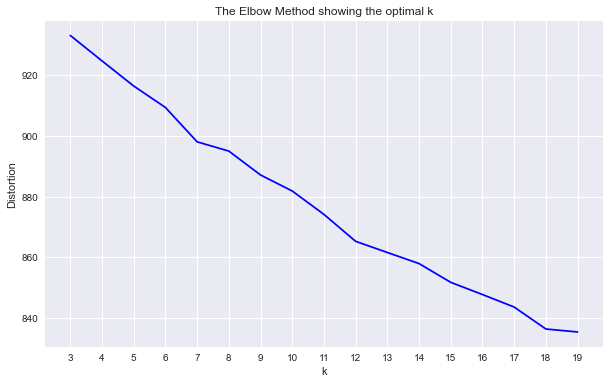

In [314]:
distortions = []
K = range(3,20) 

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(tfidf_matrix)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(K)
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Silhouette Score

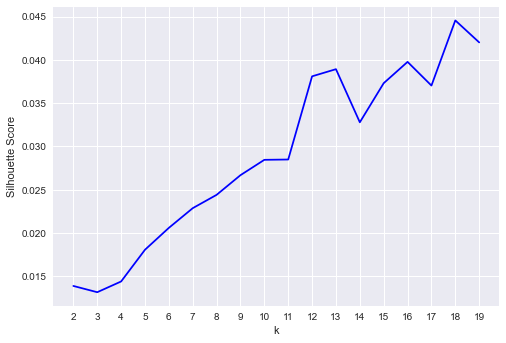

In [355]:
silhouette_scores = []
K = range(2,20)  # Typically start from 2 because silhouette doesn't work with 1 cluster

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, clusters)
    silhouette_scores.append(silhouette_avg)

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xticks(K)
plt.show()

## Perform K-means Clustering

In [142]:
# Choose an optimal number of clusters (based on the elbow in the graph) and fit the K-means model
optimal_clusters = 17
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_pred_y = kmeans.fit_predict(tfidf_matrix)

In [143]:
# Assign cluster labels to the original dataframe
df['kmeans_label'] = kmeans_pred_y

# Combine LDA with K-means Clustering

### Elbow Method

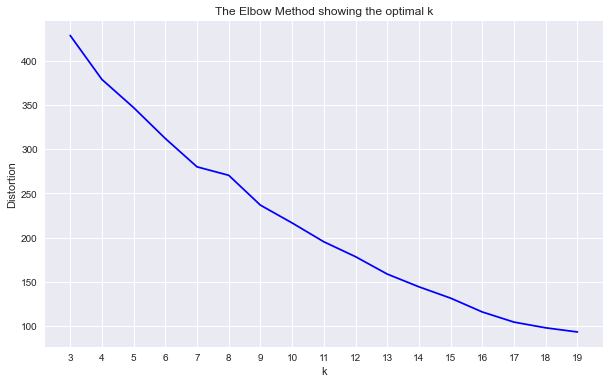

In [356]:
distortions = []
K = range(3,20) 

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(topic_results)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(K)
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Silhouette Score

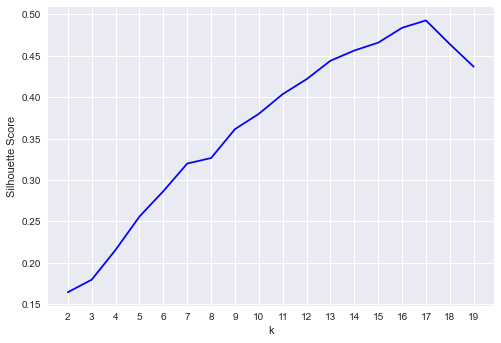

In [357]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2,20)  # Typically start from 2 because silhouette doesn't work with 1 cluster

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(topic_results)
    silhouette_avg = silhouette_score(topic_results, clusters)
    silhouette_scores.append(silhouette_avg)

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xticks(K)
plt.show()

Optimal cluster is a bit unclear but seems like 17 is reasonable.

## Perform K-means Clustering

Fit the algorithm using document-topic matrix from LDA.

In [471]:
# Choose an optimal number of clusters (based on the elbow in the graph) and fit the K-means model
optimal_clusters = 17
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
lda_kmeans_pred_y = kmeans.fit_predict(topic_results)

In [472]:
# Assign cluster labels to the original dataframe
df['lda_kmeans_label'] = lda_kmeans_pred_y

# BERT Modeling

This topic modeling technique uses transformers (BERT embeddings) and class-based TF-IDF to generate dense clusters.

In [7]:
from transformers import BertTokenizer, BertModel
import torch

In [8]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [9]:
# Feature Extraction with BERT
def get_bert_embedding(sentence, model, tokenizer):
    tokens = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Taking the mean of hidden states (Alternatively, you can use the [CLS] token's hidden state)
    return outputs.last_hidden_state.mean(dim=1)

In [10]:
bert_embeddings = torch.stack([get_bert_embedding(article, model, tokenizer) for article in df['clean_article']])

In [11]:
# Removing the singleton dimension
bert_embeddings_2D = np.squeeze(bert_embeddings, axis=1)

In [12]:
# Save to a binary file in `.npy` format
np.save('bert_embeddings_2D.npy', bert_embeddings_2D)

In [3]:
import numpy as np
bert_embeddings_2D = np.load('bert_embeddings_2D.npy')

## Perform K-means Clustering

In [9]:
# Choose an optimal number of clusters (based on the elbow in the graph) and fit the K-means model
optimal_clusters = 17
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
bert_pred_y = kmeans.fit_predict(bert_embeddings_2D)
df['bert_label'] = bert_pred_y

## UMap Dimensionality Reduction of BERT and Combine with LDA

In [12]:
import umap.umap_ as umap

In [117]:
n_components = np.arange(2, 151)
coh_score = []
for n_component in n_components:
    # Dimensionality reduction on BERT vectors
    umap_model = umap.UMAP(n_components=n_component, random_state=42) # Choose the number of components
    reduced_bert_vectors = umap_model.fit_transform(bert_embeddings_2D) # shape will be (n, k2)
    
    # Concatenation
    lda_bert_vectors = np.concatenate([topic_results, reduced_bert_vectors], axis=1) # shape will be (n, k1 + k2)

    # K-means clustering
    kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
    lda_bert_pred_y = kmeans.fit_predict(lda_bert_vectors)
    df['lda_bert_label'] = lda_bert_pred_y

    coh_score.append(get_topic_coherence(df, tfidf_vectorizer, 'lda_bert_label'))

In [126]:
n_components[np.argmax(coh_score)]

49

In [180]:
# Dimensionality reduction on BERT vectors
umap_model = umap.UMAP(n_components=49, random_state=42) # Choose the number of components
reduced_bert_vectors = umap_model.fit_transform(bert_embeddings_2D) # shape will be (n, k2)

# Concatenation
lda_bert_vectors = np.concatenate([topic_results, reduced_bert_vectors], axis=1) # shape will be (n, k1 + k2)

# K-means clustering
kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
lda_bert_pred_y = kmeans.fit_predict(lda_bert_vectors)
df['lda_bert_label'] = lda_bert_pred_y

# Evaluate Performance

### Topic Coherence

In [166]:
lda_topic_coherence = get_topic_coherence(df, tfidf_vectorizer, 'lda_label')
kmean_topic_coherence = get_topic_coherence(df, tfidf_vectorizer, 'kmeans_label')
lda_kmean_topic_coherence = get_topic_coherence(df, tfidf_vectorizer, 'lda_kmeans_label')
bert_kmean_topic_coherence = get_topic_coherence(df, tfidf_vectorizer, 'bert_label')
lda_bert_kmean_topic_coherence = get_topic_coherence(df, tfidf_vectorizer, 'lda_bert_label')

print('topic_coherence for LDA: ', np.round(lda_topic_coherence, 4))
print('topic_coherence for kmeans: ', np.round(kmean_topic_coherence, 4))
print('topic_coherence for LDA + kmeans: ', np.round(lda_kmean_topic_coherence, 4))
print('topic_coherence for BERT + kmeans: ', np.round(bert_kmean_topic_coherence, 4))
print('topic_coherence for LDA + BERT + kmeans: ', np.round(lda_bert_kmean_topic_coherence, 4))

topic_coherence for LDA:  0.4064
topic_coherence for kmeans:  0.4897
topic_coherence for LDA + kmeans:  0.4135
topic_coherence for BERT + kmeans:  0.4636
topic_coherence for LDA + BERT + kmeans:  0.4934


### Topic Diversity

In [163]:
lda_topic_diversity = get_topic_diversity(df, tfidf_vectorizer, 'lda_label')
kmeans_topic_diversity = get_topic_diversity(df, tfidf_vectorizer, 'kmeans_label')
lda_kmeans_topic_diversity = get_topic_diversity(df, tfidf_vectorizer, 'lda_kmeans_label')
bert_topic_diversity = get_topic_diversity(df, tfidf_vectorizer, 'bert_label')
lda_bert_topic_diversity = get_topic_diversity(df, tfidf_vectorizer, 'lda_bert_label')

print('topic_diversity for LDA: ', np.round(lda_topic_diversity, 4))
print('topic_diversity for kmeans: ', np.round(kmeans_topic_diversity, 4))
print('topic_diversity for LDA + kmeans: ', np.round(lda_kmeans_topic_diversity, 4))
print('topic_diversity for BERT + kmeans: ', np.round(bert_topic_diversity, 4))
print('topic_diversity for LDA + BERT + kmeans: ', np.round(lda_bert_topic_diversity, 4))

topic_diversity for LDA:  0.739
topic_diversity for kmeans:  0.8249
topic_diversity for LDA + kmeans:  0.7417
topic_diversity for BERT + kmeans:  0.7571
topic_diversity for LDA + BERT + kmeans:  0.7725


### Silhouette Score

In [178]:
kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
lda_kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
bert_kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
lda_bert_kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)

kmeans_cluster = kmeans.fit_predict(tfidf_matrix)
lda_kmeans_cluster = lda_kmeans.fit_predict(topic_results)
bert_kmeans_cluster = bert_kmeans.fit_predict(bert_embeddings_2D)
lda_bert_kmeans_cluster = lda_bert_kmeans.fit_predict(lda_bert_vectors)

print('Silhouette score for kmeans: ', silhouette_score(tfidf_matrix, kmeans_cluster))
print('Silhouette score for LDA + kmeans: ', silhouette_score(topic_results, lda_kmeans_cluster))
print('Silhouette score for BERT + kmeans: ', silhouette_score(bert_embeddings_2D, bert_kmeans_cluster))
print('Silhouette score for LDA + BERT + kmeans: ', silhouette_score(lda_bert_vectors, lda_bert_kmeans_cluster))

Silhouette score for kmeans:  0.0370320051320985
Silhouette score for LDA + kmeans:  0.4928035135701487
Silhouette score for BERT + kmeans:  0.061440688
Silhouette score for LDA + BERT + kmeans:  0.4034024996980035


# Text Summarization

Besides the quantitative metrics, I also want to use my personal judgment on whether the topics it created are accurate. Since reading the entire articles are time consuming, I am going to summarize texts for easier read.

Install RUST: https://www.rust-lang.org/tools/install

Install PyTorch: pip install torch torchvision

Install transformers

In [21]:
from transformers import BartForConditionalGeneration, BartTokenizer

In [53]:
# Load model and tokenizer
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

In [98]:
def summarize_texts(texts,
                    model,
                    tokenizer,
                    model_name='facebook/bart-large-cnn',
                    max_input_length=1024,
                    max_summary_length=100):
      
    summaries = []
    
    for text in texts:
        # Tokenize the text
        inputs = tokenizer([text], max_length=max_input_length, return_tensors='pt', truncation=True)

        # Generate summary
        summary_ids = model.generate(inputs['input_ids'],
                                     num_beams=4,
                                     max_length=max_summary_length,
                                     early_stopping=True)
        
        summarized_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summarized_text)
        
    return summaries

In [99]:
summarized_articles = summarize_texts(df['article'], model, tokenizer)

df['summarized_article'] = summarized_articles

/var/folders/sp/l9mdhsl91857chmn1wsjkfyr0000gn/T/ipykernel_6524/3357646158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['summarized_article'] = summarized_articles


## Save DataFrame to S3 After Summerization

In [162]:
# Load the environment file with credentials
dotenv_path = os.path.join(os.path.abspath(''), 'aws-credentials.env')
load_dotenv(dotenv_path)

BUCKET_NAME = "nlp-topic-modeling-project" # S3 bucket name
KEY = "processed_insurance_journal_articles.parquet" # Name of file object

session = boto3.Session(
        aws_access_key_id=os.environ['aws_access_key_id'],
        aws_secret_access_key=os.environ['aws_secret_access_key']
    )

# Creating S3 resource from Session
s3 = session.resource('s3')

# Create bucket
try:
    s3.create_bucket(Bucket=BUCKET_NAME)
    
except:
    print("Bucket already exists. Proceeding...")

# Checking if the file with the same key exists, and if so, deleting it
bucket = s3.Bucket(BUCKET_NAME)
objs = list(bucket.objects.filter(Prefix=KEY))

if len(objs) > 0 and objs[0].key == KEY:
    s3.Object(BUCKET_NAME, KEY).delete()
    print(f"Deleted existing file with key: {KEY}")

# Create a buffer, which stores the data in memory
buffer = BytesIO()

# Save the dataframe into parquet and save in the buffer
df.to_parquet(buffer)

# Store the file into S3
s3.Object(BUCKET_NAME, KEY).put(Body=buffer.getvalue())

Deleted existing file with key: processed_insurance_journal_articles.parquet


{'ResponseMetadata': {'RequestId': 'WH113BWE3D43663X',
  'HostId': 'yrydiWtDiN108VDLPJSet6dfQBQqILMbkFUgqzOQvF82YqC1ZRDmseA5gdnCJM4Cnpj4TyBGidE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'yrydiWtDiN108VDLPJSet6dfQBQqILMbkFUgqzOQvF82YqC1ZRDmseA5gdnCJM4Cnpj4TyBGidE=',
   'x-amz-request-id': 'WH113BWE3D43663X',
   'date': 'Fri, 25 Aug 2023 00:17:18 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"a71aeb4e451923c93b755fec887ce8d3"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"a71aeb4e451923c93b755fec887ce8d3"',
 'ServerSideEncryption': 'AES256'}

In [452]:
LDA_topic_article =  df[df['lda_kmeans_label'] == 2]['article_summarized']
for article in LDA_topic_article.sample(n=5):
    print(article)
    print('\n')

Frustration Grows Over Wait on OxyContin Maker’s Settlement. Lawyers on multiple sides of the case, including those representing Purdue, asked the 2nd U.S. Circuit Court of Appeals in New York to issue a ruling. About 149,000 individuals made claims and could receive between about $3,500 and $48,000 each from the settlement.


Byron Allen Sues McDonald’s for Allegedly Lying about Commitment to Black Media. Media entrepreneur Byron Allen has filed a second lawsuit against McDonald's Corp over the fast-food chain's alleged refusal to advertise with Black-owned media. The lawsuit seeks $100 million plus punitive damages for McDonald's alleged violation of a California anti-fraud law against making false promises.


Judge orders Boeing to appear in court on Jan. 26 to face felony charge. The charge is related to two fatal crashes of Boeing 737s in Indonesia and Ethiopia. The U.S. government has agreed to a $2.5 billion settlement with the families of the crash victims.


Tutoring Firm Sett

In [350]:
# def calc_topic_coherence(method, matrix, df, vectorizer, labels=None, top_n_words=20, coherence_type='c_v'):
#     """
#     Computes the coherence score for topics derived from either LDA or KMeans clustering.

#     Parameters:
#     - method: either 'lda' or 'kmean' to specify the technique.
#     - matrix: If method='lda', this is the Topic to word matrix. 
#               If method='kmean', this is the TF-IDF matrix.
#               If method='lda_kmeans', this is document to topic matrix.
#     - vectorizer: If method='lda', CountVectorizer. Otherwise, TfidfVectorizer used.
#     - labels: Cluster labels (required if method is 'lda_kmean' or 'kmean').
#     - top_n_words: Number of top words to consider for each topic in coherence computation.
#     - coherence_type: Type of coherence measure to use (e.g., 'c_v').

#     Returns:
#     - coherence_score: Coherence score for the topics.
#     """
                  
#     # Tokenize documents
#     texts = [doc.split() for doc in df['clean_article']]

#     # Create a Gensim dictionary
#     dictionary = Dictionary(texts)

#     # Get topics
#     topics = []
    
#     if method == 'lda':
#         for topic_idx, topic in enumerate(matrix):
#             top_features_ind = topic.argsort()[-top_n_words:][::-1]
#             top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
#             topics.append(top_features)
    
#     elif method == 'kmeans':
#         if labels is None:
#             raise ValueError("For method='kmeans', labels must be provided.")
        
#         for cluster_id in set(labels):
#             docs_in_cluster = matrix[np.array(labels) == cluster_id].toarray()
#             avg_tf_idf = np.mean(docs_in_cluster, axis=0)
#             top_indices = avg_tf_idf.argsort()[-top_n_words:][::-1]
#             top_features = [vectorizer.get_feature_names_out()[i] for i in top_indices]
#             topics.append(top_features)
            
#     elif method == 'lda_kmeans':
#         if labels is None:
#             raise ValueError("For method='lda_kmeans', labels must be provided.")
            
#         for cluster_id in set(labels):
            
#             # Take the mean topic distribution in each K-means cluster
#             mean_topic_dist = np.mean(matrix[labels == cluster_id, :], axis=0)
        
#             # Get the top N words for this "mean topic"
#             top_word_indices = mean_topic_dist.argsort()[-top_n_words:][::-1]
#             top_features = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]

#             topics.append(top_features)
        
#     else:
#         raise ValueError("Invalid method. Choose either 'lda', 'kmean', or 'lda_kmeans'.")

#     # Compute Coherence Score
#     coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=coherence_type)
#     coherence_score = coherence_model.get_coherence()
    
#     return coherence_score

In [ ]:
# def get_topic_vectors(df, column_label, vectorizer):
#     topic_vectors = []
#     for label in df[column_label].unique():
#         # Get documents with this label
#         docs_in_cluster = df[df[column_label] == label]['clean_article'].tolist()
        
#         # Convert the list of documents to a single string
#         all_words = ' '.join(docs_in_cluster)
        
#         # Vectorize the aggregated text
#         topic_vector = vectorizer.transform([all_words]).toarray()[0]
        
#         topic_vectors.append(topic_vector)
        
#     return np.array(topic_vectors)

In [391]:
# def kmean_calc_topic_diversity(matrix, labels):
#     """
#     Compute the topic diversity of clusters based on the mean TF-IDF vectors.
    
#     Args:
#     - matrix (np.ndarray): Document-term matrix (e.g., from TF-IDF). Each row is a document and each column is a term.
#     - labels (list): Cluster labels for each document.
    
#     Returns:
#     - float: Topic diversity score
#     """
    
#     unique_labels = list(set(labels))
#     cluster_vectors = []

#     # Create "topic" vectors for each cluster by averaging TF-IDF vectors of the cluster's documents
#     for label in unique_labels:
#         # This is like doing groupby labels. Boolean indexing of selecting rows with desired label.
#         docs_in_cluster = matrix[np.array(labels) == label].toarray()
#         # axis=0 means I am finding mean for individual columns, keeping column dimension the same.
#         avg_vector = np.mean(docs_in_cluster, axis=0)
#         # For each label, I am creating a tfidf vector.
#         cluster_vectors.append(avg_vector)
    
#     # Convert list of vectors into a matrix
#     topic_word_distribution = np.array(cluster_vectors)
    
#     # Normalize topic-word matrix
#     topic_word_distribution = topic_word_distribution / topic_word_distribution.sum(axis=1)[:, np.newaxis]
    
#     # Compute pairwise cosine similarity
#     similarities = cosine_similarity(topic_word_distribution)
    
#     # Subtract the identity matrix to set diagonal values to 0
#     similarities -= np.identity(similarities.shape[0])
    
#     # Return the average similarity (or 1 - average similarity for diversity)
#     return 1 - np.mean(similarities)

In [ ]:
# def lda_kmeans_topic_diversity(lda_topic_word_matrix, kmeans_labels):
#     """
#     Compute the topic diversity of clusters based on both the LDA topic-word matrix and KMeans labels.
    
#     Args:
#     - lda_topic_word_matrix (np.ndarray): Topic-word matrix from LDA. Each row is a topic and each column is a word.
#     - kmeans_labels (list): Cluster labels for each topic.
    
#     Returns:
#     - float: Topic diversity score
#     """

#     # Normalizing the LDA topic-word matrix
#     lda_topic_word_matrix = lda_topic_word_matrix / lda_topic_word_matrix.sum(axis=1)[:, np.newaxis]
    
#     unique_labels = set(kmeans_labels)
#     aggregated_topics = []

#     for label in unique_labels:
#         topics_in_cluster = lda_topic_word_matrix[kmeans_labels == label, :]
#         # Average the topics in each cluster
#         avg_topic = np.mean(topics_in_cluster, axis=0)
#         aggregated_topics.append(avg_topic)

#     # Convert list of aggregated topics into a matrix
#     aggregated_matrix = np.array(aggregated_topics)
    
#     # Normalize the aggregated topic-word matrix
#     aggregated_matrix = aggregated_matrix / aggregated_matrix.sum(axis=1)[:, np.newaxis]

#     # Compute pairwise cosine similarity
#     similarities = cosine_similarity(aggregated_matrix)
    
#     # Subtract the identity matrix to set diagonal values to 0
#     similarities -= np.identity(similarities.shape[0])
    
#     # Return the average similarity (or 1 - average similarity for diversity)
#     return 1 - np.mean(similarities)


In [431]:
# def word_plot(idx, matrix, vectorizer, method='lda', labels=None, n_words=30):
#     """
#     Plots the top words for a specified topic or cluster using provided word weights \
#     (like LDA components or average TF-IDF).

#     Parameters:
#     - idx: Index of the topic or cluster for which you want to plot the top words.
#     - matrix: Matrix of word weights (e.g., LDA components or  TF-IDF values for clusters).
#     - vectorizer: Fitted vectorizer (like TF-IDF or CountVectorizer).
#     - method: Either 'lda' or 'kmeans' to specify the source of the matrix.
#     - n_words: Number of top words to plot.
#     """
    
#     if method == 'kmeans':
#         # Get matrix per cluster
#         cluster_vectors = matrix[np.array(labels) == idx].toarray()
    
#         # Calculate the average TF-IDF vector for the cluster
#         word_weights = np.mean(cluster_vectors, axis=0)
    
#     elif method == 'lda':
        
#         # Get the word weights for the specified topic
#         word_weights = matrix[idx]

#     # Get the indices for the top words
#     top_word_indices = word_weights.argsort()[-n_words:][::-1]

#     # Get the words corresponding to these indices
#     feature_names = vectorizer.get_feature_names_out()
#     top_words = [feature_names[i] for i in top_word_indices]

#     # Plot horizontal bar chart
#     plt.figure(figsize=(15, 10))
#     plt.barh(top_words, word_weights[top_word_indices])
#     plt.xlabel('Weight')

#     # Set title based on method
#     if method == 'lda':
#         plt.title(f'Top {n_words} words for topic {idx}')
#     elif method == 'kmeans':
#         plt.title(f'Top {n_words} words for cluster {idx}')
#     else:
#         raise ValueError("Method should be either 'LDA' or 'KMeans'.")

#     plt.gca().invert_yaxis()
#     plt.show()

## Autoencoder Dimension Reduction of BERT and Combine With LDA

In [181]:
# # Concatenation
# lda_bert_vectors = np.concatenate([topic_results, bert_embeddings_2D], axis=1) # shape will be (n, k1 + k2)

# X_train, X_test = train_test_split(lda_bert_vectors, test_size=0.2)

# latent_dims = np.arange(5, 100, 5)
# coh_score2 = []

# for latent_dim in latent_dims:
    
#     # Define Autoencoder Model
#     input_dim = lda_bert_vectors.shape[1]
#     activation = 'relu'
#     input_vec = Input(shape=(input_dim,))
#     encoded = Dense(latent_dim, activation=activation)(input_vec)
#     decoded = Dense(input_dim, activation=activation)(encoded)
#     autoencoder = Model(input_vec, decoded)
#     encoder = Model(input_vec, encoded)

#     autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#     # Train Autoencoder
#     autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, shuffle=True, validation_data=(X_test, X_test), verbose=0)

#     # Use Encoder to get lower-dimensional representation
#     encoded_vec = encoder.predict(lda_bert_vectors)

#     # K-means clustering on encoded vectors
#     kmeans = KMeans(n_clusters=17, init='k-means++', max_iter=300, n_init=10, random_state=42)
#     lda_bert_pred_y = kmeans.fit_predict(encoded_vec)
#     df['lda_bert_label2'] = lda_bert_pred_y
    
#     coh_score2.append(get_topic_coherence(df, tfidf_vectorizer, 'lda_bert_label2'))